# Co-authors

This page focuses on co-authorship in the *XVIIIe siècle: Bibliographie*. 

In [44]:
# === Imports === 

import re 
import seaborn as sns
from matplotlib import pyplot as plt
from os.path import join, abspath, normpath, realpath
import os
from lxml import etree
from io import StringIO, BytesIO
from collections import Counter
import pandas as pd
import numpy as np
from IPython.display import HTML, display   
import networkx as nx
from pyvis.network import Network 
import matplotlib.pyplot as plt


# === Namespaces === 

namespaces = {
    "foaf" : "http://xmlns.com/foaf/0.1/",
    "bib" : "http://purl.org/net/biblio#",
    "dc" : "http://purl.org/dc/elements/1.1/",
    "z" : "http://www.zotero.org/namespaces/export#",
    "rdf" : "http://www.w3.org/1999/02/22-rdf-syntax-ns#"
    }


# === Files and parameters === 

wdir = join("/", "media", "christof", "Data", "Github", "christofs", "BIB18")
bibdatafile = join(wdir, "data", "BIB18_Zotero-RDF_2024-01-02.rdf") 
#bibdatafile = join(wdir, "data", "BIB18_Zotero-RDF_TEST.rdf") 


# === Load the dataset === 

def read_xml(bibdatafile): 
    bibdata = etree.parse(bibdatafile)
    return bibdata
bibdata = read_xml(bibdatafile)

## Number of collaborators in co-authorship

This section determines how frequent co-authorship is in the dataset. This is based on the number of names found within the "authors" element. For a comparison with co-editorship, see the section [Co-editors](co-editors.html). 

In [45]:
def get_coauthors(bibdata): 
    """
    Extracts the authorship information from the data. 
    """
    # First, find all lists of authors
    xpath = "//bib:authors"
    authors = bibdata.xpath(xpath, namespaces=namespaces)
    print("There are " + str(len(authors)) +  " publications with a list of one or several authors in the dataset.")

    # Then, for each publication, get the list of authors (first and last name)
    coauthors = []
    xpath_lastname = ".//foaf:surname/text()"
    xpath_firstname = ".//foaf:givenName/text()"
    for item in authors: 
        lastnames = item.xpath(xpath_lastname, namespaces=namespaces)
        firstnames = item.xpath(xpath_firstname, namespaces=namespaces)
        fullnames = []
        for last, first in zip(lastnames, firstnames):
            full = last + "_" + first
            fullnames.append(full)
        if fullnames: 
            coauthors.append(fullnames)
    return coauthors
coauthors = get_coauthors(bibdata)

There are 56839 publications with a list of one or several authors in the dataset.


As the next step, we want to see how many authors publications in the bibliography typically have, expressed both in counts and in percentages. The table below shows the results. 

In [46]:
def get_coauthordata(coauthors): 

    # Get count of coauthor numbers
    count_coauthors = Counter([len(item) for item in coauthors])

    # Turn into a dataframe
    coauthordata = pd.DataFrame.from_dict(
        count_coauthors,
        orient="index",
        columns=["count"])

    # Calculate percentages
    coauthors_sum = np.sum(coauthordata["count"])
    coauthordata["percentage"] = np.round(np.multiply(coauthordata["count"] / coauthors_sum, 100), 2)

    # Prettify the DataFrame
    coauthordata["number"] = coauthordata.index
    coauthordata = coauthordata.sort_values(by="number")
    coauthordata = coauthordata[['number', 'count', 'percentage']]
    display(HTML(coauthordata.to_html(index=False)))

    return coauthordata
coauthordata = get_coauthordata(coauthors)

number,count,percentage
1,52635,94.16
2,3244,5.80
3,13,0.02
4,5,0.01


Of course, we can also display these results as a bar chart, for easier visual inspection  (and comparison to the barchart in the [Co-editor section](coeditors.html).)

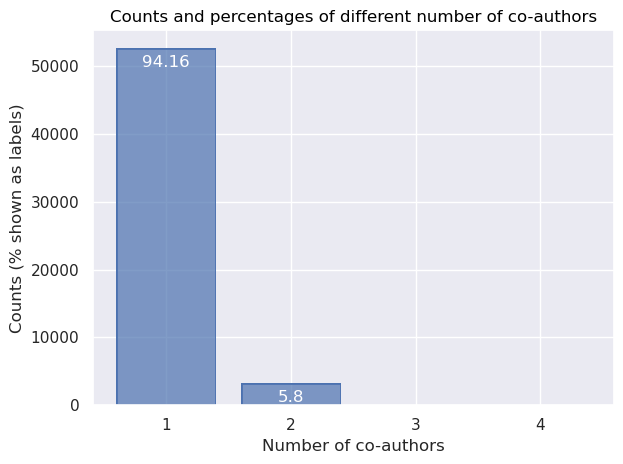

In [47]:
def visualize_coauthordata(coauthordata): 
    """
    Create a simple bar plot that shows 
    the percentage of each count of co-authors in the dataset.
    """

    import seaborn.objects as so
    (
        so.Plot(data=coauthordata, x="number", y="count", text="percentage")
        .add(so.Bar())
        .add(so.Text(color="w", valign="top", offset=5))
        .scale(x=so.Continuous().tick(every=1))
        .label(
            x="Number of co-authors",
            y="Counts (% shown as labels)",
            title = "Counts and percentages of different number of co-authors")
        .save("figures/coauthor-percentages.png", dpi=300)
        .show()
    )
visualize_coauthordata(coauthordata)

Regarding authorship (of books, articles and chapters), the figure above shows that single authorship is clearly the norm in this dataset (with around 94% of the cases). The remaining 6% are alsmost all cases of dual authorship, with a rare exceptions of triple or more authorship. 

In contrast, when looking at editorship, joint editorship with two editors is the most common case (around 42%), closely followed by single editorship (almost 40%). Triple co-editorship is rarer, but not uncommon (at around 14%). 

## Coauthor pairs

Even if coauthorship is comparatively rare, we can still try to build a network of co-authors. The table below shows the people most frequently authoring a publication jointly. 

In [60]:
import warnings
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


def network_coauthors(coauthordata): 
    """
    Builds the network of people having collaborated as authors. 
    """

    # Filter out the single author data
    coauthors = [item for item in coauthordata if len(item) > 1]

    # Establish the count of each collaboration between authors
    import itertools 
    all_coauthor_combinations = []
    for item in coauthors: 
        coauthors_combinations = list(itertools.combinations(item, 2))
        coauthors_combinations = [tuple(sorted(item)) for item in coauthors_combinations]
        for coauthcomb in coauthors_combinations: 
            all_coauthor_combinations.append(coauthcomb)
    cac = dict(Counter(all_coauthor_combinations)) # ccc = coeditor_combinations_count

    # Transform to a DataFrame
    cac = pd.DataFrame.from_dict(cac, orient="index", columns=["count"])
    cac = cac.reset_index()
    cac_split = pd.DataFrame(cac["index"].tolist())
    cac_merged = cac_split.merge(cac, left_index=True, right_index=True)
    cac = cac_merged.drop(["index"], axis=1)
    cac = cac.rename({0 : "coauthor1", 1 : "coauthor2"}, axis=1)
    cac = cac.sort_values(by="count", ascending=False)
    display(HTML(cac.head(15).to_html(index=False)))

    return cac
cac = network_coauthors(coauthors)

coauthor1,coauthor2,count
Albertan_Christian,Chouillet_Anne-Marie,22
Desberg_Stephen,Marini_Enrico,15
Berchtold_Jacques,Porret_Michel,12
Cabane_Franck,Chouillet_Anne-Marie,10
Boussuge_Emmanuel,Launay_Françoise,9
Hourcade_Philippe,Vinha_Mathieu Da,9
Brown_Andrew,Kölving_Ulla,8
Chouillet_Anne-Marie,Loty_Laurent,8
Adelson_Robert,Letzter_Jacqueline,7
Lüsebrink_Hans-Jürgen,Reichardt_Rolf,7


## Co-author networks

Based on the coauthor pairs, we can now build a network visualisation. 

In [61]:
def create_plot(cac, topn): 
    """ 
    Plot the co-editor data as a network using pyvis. 
    """
    
    # Filter the dataset 
    # Determine the top N most frequent co-editors
    coauthors_top = list(set(list(cac.head(topn).loc[:,"coauthor1"]) +\
        list(cac.head(topn).loc[:,"coauthor2"])))

    print("Among all authors, " + str(len(coauthors_top)) + " have been selected as the most active co-authors.")

    # Filter the DataFrame to include just the collaborations involving at least one of the top co-authors. 
    # The resulting DataFrame will have all collaborations between the top co-editors and their co-authors. 
    cac = cac[(cac["coauthor1"].isin(coauthors_top)) |\
                       (cac["coauthor2"].isin(coauthors_top))]

    # Simplify the labels 
    cac.loc[:,'coauthor1'] =  [re.sub(r', .*','', str(x)) for x in cac.loc[:,'coauthor1']]
    cac.loc[:,'coauthor2'] =  [re.sub(r', .*','', str(x)) for x in cac.loc[:,'coauthor2']]

    # Prepare the dataset
    cac.rename(columns={"count": "weight"}, inplace=True)
    cac = cac[cac["weight"] > 0] # for filtering, with "0", all items remain

    # Load the data into a NetworkX graph
    net = Network('1600px', '2800px', notebook=True, cdn_resources='in_line')
    G = nx.Graph()
    for line in cac.iterrows(): 
        #print(line[1][0], end="\n")
        G.add_edge(
            # full names
            line[1][0],
            line[1][1],
            # last names only
            #re.split("_", line[1][0])[0],
            #re.split("_", line[1][1])[0],
            weight=line[1][2],
            title=line[1][2],
            )
    degrees = dict(G.degree)
    degrees.update((x, ((y*50)**0.5)) for x, y in degrees.items())
    nx.set_node_attributes(G, degrees, 'size') 
    print("With all their co-authors, the network includes a total of", str(nx.number_of_nodes(G)), "authors.")

    # Plot the data using pyvis
    net.from_nx(G)
    net.toggle_physics(True)
    net.show("figures/coauthor-network.html")
create_plot(cac, topn=100)


Among all authors, 183 have been selected as the most active co-authors.
With all their co-authors, the network includes a total of 354 authors.
figures/coauthor-network.html


Click on the following plot to load the interactive, zoomable and scrollable network. 

[![](figures/coauthor_network_dummy.png)](figures/coauthor-network.html)

At a first glance, especially when compared to the dense co-editor network, what strikes here is the relative sparsity of the connections. There is a more densely-connected subnetwork at the center, but there are also many unconnected subnetworks of co-authorship.